In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

# 1.数据加载

In [2]:
import os
print(os.getcwd())

e:\Machine_learning\deeplearning


In [3]:
train_data0 = pd.read_csv('data/ca_ho_pr/train.csv')
test_data = pd.read_csv('data/ca_ho_pr/test.csv')

In [4]:
print(train_data0.shape)
print(test_data.shape)
train_data0.dtypes

(47439, 41)
(31626, 40)


Id                               int64
Address                         object
Sold Price                     float64
Summary                         object
Type                            object
Year built                     float64
Heating                         object
Cooling                         object
Parking                         object
Lot                            float64
Bedrooms                        object
Bathrooms                      float64
Full bathrooms                 float64
Total interior livable area    float64
Total spaces                   float64
Garage spaces                  float64
Region                          object
Elementary School               object
Elementary School Score        float64
Elementary School Distance     float64
Middle School                   object
Middle School Score            float64
Middle School Distance         float64
High School                     object
High School Score              float64
High School Distance     

In [5]:
train_labels = train_data0['Sold Price']
train_data = train_data0.drop('Sold Price', axis=1)
train_labels, train_data0.dtypes

(0        3825000.0
 1         505000.0
 2         140000.0
 3        1775000.0
 4        1175000.0
            ...    
 47434     159000.0
 47435     255000.0
 47436    2300000.0
 47437     500000.0
 47438     760000.0
 Name: Sold Price, Length: 47439, dtype: float64,
 Id                               int64
 Address                         object
 Sold Price                     float64
 Summary                         object
 Type                            object
 Year built                     float64
 Heating                         object
 Cooling                         object
 Parking                         object
 Lot                            float64
 Bedrooms                        object
 Bathrooms                      float64
 Full bathrooms                 float64
 Total interior livable area    float64
 Total spaces                   float64
 Garage spaces                  float64
 Region                          object
 Elementary School               object
 Elementar

In [6]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(test_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
train_data.shape, test_data.shape

   Id            Address                                            Summary  \
0   0        540 Pine Ln  540 Pine Ln, Los Altos, CA 94022 is a single f...   
1   1     1727 W 67th St  HURRY, HURRY.......Great house 3 bed and 2 bat...   
2   2     28093 Pine Ave  'THE PERFECT CABIN TO FLIP!  Strawberry deligh...   
3   3  10750 Braddock Dr  Rare 2-story Gated 5 bedroom Modern Mediterran...   

           Type         City    Zip State  
0  SingleFamily    Los Altos  94022    CA  
1  SingleFamily  Los Angeles  90047    CA  
2  SingleFamily   Strawberry  95375    CA  
3  SingleFamily  Culver City  90230    CA  
      Id                    Address  \
0  47439        3034 N Coolidge Ave   
1  47440         565 Kenilworth Ave   
2  47441        3028 N Coolidge Ave   
3  47442  3022 N North Coolidge Ave   

                                             Summary          Type  \
0  Live within steps to the scenic views on the L...  SingleFamily   
1                 duplex fixer. Input for comps 

((47439, 40), (31626, 40))

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
all_features.dtypes

Address                         object
Summary                         object
Type                            object
Year built                     float64
Heating                         object
Cooling                         object
Parking                         object
Lot                            float64
Bedrooms                        object
Bathrooms                      float64
Full bathrooms                 float64
Total interior livable area    float64
Total spaces                   float64
Garage spaces                  float64
Region                          object
Elementary School               object
Elementary School Score        float64
Elementary School Distance     float64
Middle School                   object
Middle School Score            float64
Middle School Distance         float64
High School                     object
High School Score              float64
High School Distance           float64
Flooring                        object
Heating features         

# 2.数据预处理

In [8]:
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
# 1.构造 临近房价，相同Zip相同值
zip_price = train_data0.groupby('Zip')["Sold Price"].median().rename('Near Price')
# zip_price['Zip'] = train_data0['Zip']
all_features = all_features.merge(zip_price, on='Zip', how='left')
# 2.构造 上次售出至本次挂牌时间
all_features['LS Time'] = (pd.to_datetime(all_features['Listed On']) - pd.to_datetime(all_features['Last Sold On'])).dt.days
# 3. Bedroom & bathroom number
all_features['Bedrooms'] = pd.to_numeric(all_features['Bedrooms'], errors='coerce')
all_features['Bathrooms'] = pd.to_numeric(all_features['Bathrooms'], errors='coerce')
# 4. School features
# all_features['Education'] = all_features["Elementary School Score"].fillna(0) / (1 + all_features["Elementary School Distance"].fillna(0)) + all_features["Middle School Score"].fillna(0) / (1 + all_features["Middle School Distance"].fillna(0)) + all_features["High School Score"].fillna(0) / (1 + all_features["High School Distance"].fillna(0))
# 5.其他特征
all_features['Listed_Year'] = pd.to_datetime(all_features['Listed On']).dt.year
all_features['Listed_Month'] = pd.to_datetime(all_features['Listed On']).dt.month

# 5. Drop out
# all_features = all_features.drop(columns=['Listed On', 'Last Sold On', 'Zip', 
#                 'Elementary School Score', 'Elementary School Distance', 
#                 'Middle School Score', 'Middle School Distance', 
#                 'High School Score', 'High School Distance'])
all_features = all_features.drop(columns=['Listed On', 'Last Sold On', 'Zip'])
all_features.shape

(79065, 40)

In [9]:
# 数值型特征处理
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# extreme_values = all_features[numeric_features].quantile(0.99)
# all_features[numeric_features] = all_features[numeric_features].clip(
#                                 upper=extreme_values, axis=1)
large_val_col = ['Lot', 'Total interior livable area', 'Tax assessed value',
                 'Annual tax amount', 'Listed Price']
large_values = all_features[large_val_col].fillna(0)
for col in large_val_col:
    all_features[col] = np.log1p(large_values[col])

# Normalization
for col in numeric_features:
    all_features[col] = (all_features[col] - all_features[col].mean()) / all_features[col].std()

# Fill Nan
all_features[numeric_features] = all_features[numeric_features].fillna(all_features[numeric_features].mean())

In [10]:
# Not numberical features
all_features = all_features[list(numeric_features) + ['Type']]
all_features = pd.get_dummies(all_features, dummy_na=True, dtype=int)
all_features.shape

(79065, 197)

In [11]:
# 1.Data preparation
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_labels.values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

In [22]:
# 2.Model Class
class Net(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        self.num_inputs = num_inputs
        self.dense1 = nn.Linear(num_inputs, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dense2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dense3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dense4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        X = self.relu(self.dense1(X))
        # X = self.bn1(X)
        X = self.relu(self.dense2(X))
        # X = self.bn2(X)
        X = self.relu(self.dense3(X))
        # X = self.bn3(X)
        X = self.dense4(X)
        return X

In [13]:
# in_features = train_features.shape[1]
# net = Net(in_features)

# 3.训练模型

In [25]:
loss = nn.HuberLoss(delta=1.0)
# loss = nn.MSELoss()
def log_rmse(net, features, labels):
    # 将小于1的数值设为1，提高稳定性
    clipped_preds = torch.clamp(net(features), 1, float("inf"))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))
    return rmse.item() # item()将张量转换为Python数值

In [15]:
# 参数初始化
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [19]:
def train(train_features, train_labels, vali_features,
          num_epochs, learning_rate, weight_decay, batch_size, vali_labels=None):
    train_ls, vali_ls = [], []
    animator = d2l.Animator(xlabel='epoch', ylabel='rmse', legend=['train'])
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    net = Net(train_features.shape[1])
    net.apply(init_weights)
    # 使用 Adam 优化器
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate,
                                 weight_decay=weight_decay)    
    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        net.eval()              
        with torch.no_grad():
            train_ls.append(log_rmse(net, train_features, train_labels))  
            animator.add(epoch + 1, train_ls[-1])
        if vali_labels is not None:
            vali_ls.append(log_rmse(net, vali_features, vali_labels))
    return train_ls, vali_ls, net

avg train loss rmse 0.12289


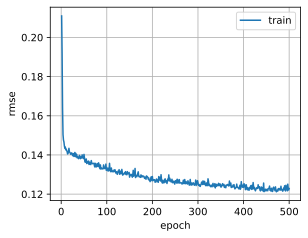

In [28]:
num_epochs, learning_rate, weight_decay, batch_size = 500, 0.01, 0.05, 128
train_l, valid_l, net = train(train_features, 
                         train_labels, test_features, num_epochs, 
                         learning_rate, weight_decay, batch_size)

print(f'avg train loss rmse {train_l[-1]:<.5f}')
# print('%d-fold validation: avg train loss rmse %f, avg valid loss rmse %f' % (
        #   k, train_l, valid_l))

# 4.提交预测

In [29]:
# 预测数值，并保存至submission.csv
# test_data['Sold Price'] = k_fold_predict(pred_nets, test_features)
test_data['Sold Price'] = net(test_features).detach().numpy()
submission = pd.concat([test_data[['Id']], test_data[['Sold Price']]], axis=1)
submission.to_csv('submission_california_4.csv', index=False)

# AutoML 实现

In [25]:
from autogluon.tabular import TabularDataset, TabularPredictor
import pandas as pd
# train
train_data = TabularDataset('..\data\kaggle_house_pred_train.csv')
id, label = 'Id', 'SalePrice'
predictor = TabularPredictor(label=label).fit(
    train_data.drop(columns=[id]))

# predict
test_data = TabularDataset('..\data\kaggle_house_pred_test.csv')
predictions = predictor.predict(test_data.drop(columns=[id]))

# submit
submission = pd.DataFrame({id: test_data[id], label: predictions})
submission.to_csv('submission.csv', index=False)

Loaded data from: ..\data\kaggle_house_pred_train.csv | Columns = 81 / 81 | Rows = 1460 -> 1460


No path specified. Models will be saved in: "AutogluonModels\ag-20250818_131816"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.4.0
Python Version:     3.10.18
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          16
Memory Avail:       8.00 GB / 15.67 GB (51.0%)
Disk Space Avail:   172.44 GB / 465.75 GB (37.0%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='extreme' : New in v1.4: Massively better than 'best' on datasets <30000 samples by using new models meta-learned on https://tabarena.ai: TabPFNv2, TabICL, Mitra, and TabM. Absolute best accuracy. Requires a GPU. Recommended 64 GB CPU memory and 32+ GB GPU memory.
	presets='best'    : Maximize acc

[1000]	valid_set's rmse: 26908.7
[2000]	valid_set's rmse: 26617.6
[3000]	valid_set's rmse: 26569.8
[4000]	valid_set's rmse: 26566.1
[5000]	valid_set's rmse: 26569.2


	-26566.0786	 = Validation score   (-root_mean_squared_error)
	3.3s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: LightGBM ...
	Fitting with cpus=12, gpus=0, mem=0.0/8.1 GB


[1000]	valid_set's rmse: 29319.9
[2000]	valid_set's rmse: 28847.1
[3000]	valid_set's rmse: 28706.5
[4000]	valid_set's rmse: 28663.8
[5000]	valid_set's rmse: 28654.9
[6000]	valid_set's rmse: 28653.7
[7000]	valid_set's rmse: 28653.3
[8000]	valid_set's rmse: 28653.3
[9000]	valid_set's rmse: 28653.4


	-28653.3015	 = Validation score   (-root_mean_squared_error)
	7.94s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: RandomForestMSE ...
	Fitting with cpus=16, gpus=0
	-32547.6926	 = Validation score   (-root_mean_squared_error)
	0.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: CatBoost ...
	Fitting with cpus=12, gpus=0
	-30800.849	 = Validation score   (-root_mean_squared_error)
	339.82s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	Fitting with cpus=16, gpus=0
	-31938.3616	 = Validation score   (-root_mean_squared_error)
	0.63s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	Fitting with cpus=12, gpus=0, mem=0.0/7.3 GB
	-31737.9798	 = Validation score   (-root_mean_squared_error)
	2.26s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	Fitting with cpus=12, gpus=0
	-29812.6009	 = Validation score   (-root_mean_squared_error)
	2.61s	 = Tra

[1000]	valid_set's rmse: 29504.4


	-29504.1986	 = Validation score   (-root_mean_squared_error)
	4.35s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'LightGBMXT': 0.8, 'XGBoost': 0.2}
	-26337.5824	 = Validation score   (-root_mean_squared_error)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 367.45s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 4631.1 rows/s (292 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("e:\Machine_learning\deeplearning\Dive_into_DL\AutogluonModels\ag-20250818_131816")
Loaded data from: ..\data\kaggle_house_pred_test.csv | Columns = 80 / 80 | Rows = 1459 -> 1459
